In [9]:
import numpy as np
import lmdb
import caffe
import os
import random
from PIL import Image

In [10]:
network_inputs_dir = u'C:\\Users\\Mikhail\\Documents\\Diploma\\Images\\simple_set_cropped_united_black_transformed\\'
network_outputs_dir = u'C:\\Users\\Mikhail\\Documents\\Diploma\\Images\\simple_set_cropped_united_black_transformed\\'
image_size = 23

In [11]:
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [12]:
N_inputs = len(os.listdir(network_inputs_dir))
N_outputs = len(os.listdir(network_outputs_dir))
N = N_inputs

In [13]:
random_permutation = range(0, N)
random.shuffle(random_permutation)

In [14]:
def pack_lmdb(source_dir, label, normalize):
    
    inputs = os.listdir(source_dir)
    
    train_size = int(0.7 * N)
    train_indices = random_permutation[:train_size]
    test_indices = random_permutation[train_size:]
    
    X_train = np.zeros((train_size, 1, image_size, image_size), dtype=np.uint8)
    y_train = np.zeros(train_size, dtype=np.int64)
    
    X_test = np.zeros((N - train_size, 1, image_size, image_size), dtype=np.uint8)
    y_test = np.zeros(N - train_size, dtype=np.int64)

    # We need to prepare the database for the size. We'll set it 10 times
    # greater than what we theoretically need. There is little drawback to
    # setting this too big. If you still run into problem after raising
    # this, you might want to try saving fewer entries in a single
    # transaction
    
    filenames = inputs
    filenames_train = [filenames[i] for i in train_indices]
    filenames_test = [filenames[i] for i in test_indices]
    
    for file_index in range(len(filenames_train)):
        image = np.array(Image.open(source_dir + filenames_train[file_index])).astype(np.uint8)
        image = image[np.newaxis]
        X_train[file_index] = image
        
        #if normalize:
        #    X_train[file_index] = X_train[file_index] * 2 - 255
        
        y_train[file_index] = file_index
        
    for file_index in range(len(filenames_test)):
        image = np.array(Image.open(source_dir + filenames_test[file_index])).astype(np.uint8)
        image = image[np.newaxis]
        X_test[file_index] = image
        
        #if normalize:
        #    X_test[file_index] = X_test[file_index] * 2 - 255
        
        y_test[file_index] = file_index
    
    train = lmdb.open('train_lmdb_1_4_' + label, map_size=X_train.nbytes * 4)    
    with train.begin(write=True) as txn:
        # txn is a Transaction object
        for i in range(len(train_indices)):
            datum = caffe.proto.caffe_pb2.Datum()
            datum.channels = X_train.shape[1]
            datum.height = X_train.shape[2]
            datum.width = X_train.shape[3]
            datum.data = X_train[i].tobytes()  # or .tostring() if numpy < 1.9
            datum.label = int(y_train[i])
            str_id = '{:08}'.format(i)
            txn.put(str_id.encode('ascii'), datum.SerializeToString())
    
    test = lmdb.open('test_lmdb_1_4_' + label, map_size=X_test.nbytes * 4)    
    with test.begin(write=True) as txn:
        # txn is a Transaction object
        for i in range(len(test_indices)):
            datum = caffe.proto.caffe_pb2.Datum()
            datum.channels = X_test.shape[1]
            datum.height = X_test.shape[2]
            datum.width = X_test.shape[3]
            datum.data = X_test[i].tobytes()  # or .tostring() if numpy < 1.9
            datum.label = int(y_test[i])
            str_id = '{:08}'.format(i)
            txn.put(str_id.encode('ascii'), datum.SerializeToString())

In [15]:
pack_lmdb(network_inputs_dir, 'glyphs', False)

In [16]:
pack_lmdb(network_outputs_dir, 'fonts', False)

In [23]:
N = len(os.listdir(network_inputs_dir))

inputs = os.listdir(network_inputs_dir)
outputs = os.listdir(network_outputs_dir)

errors = []

for index in range(N):
    input_image = np.array(Image.open(network_inputs_dir + inputs[index])).astype(np.uint8)
    output_image = np.array(Image.open(network_outputs_dir + inputs[index])).astype(np.uint8)
    input_image = input_image.flatten()
    output_image = output_image.flatten()
    input_image = input_image * 0.0039215684
    output_image = output_image * 0.0039215684
    errors.append(np.linalg.norm(input_image - output_image))

In [24]:
print sum(errors) / len(errors)

In [25]:
print min(errors)

In [26]:
print max(errors)

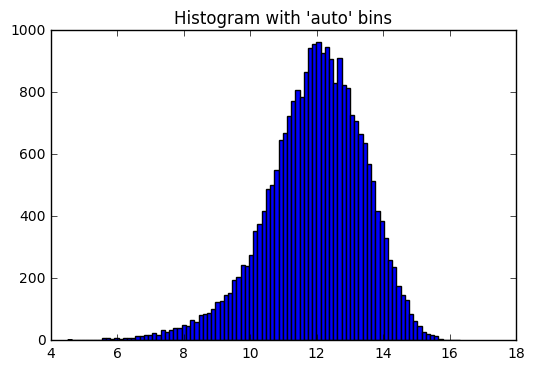

In [27]:
%inline

import matplotlib.pyplot as plt

plt.hist(errors, bins='auto')  # plt.hist passes it's arguments to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [28]:
N = len(os.listdir(network_inputs_dir))

inputs = os.listdir(network_inputs_dir)
outputs = os.listdir(network_outputs_dir)

random_permutation = range(0, N)
random.shuffle(random_permutation)

errors = []

for index in range(N):
    input_image = np.array(Image.open(network_inputs_dir + inputs[index])).astype(np.uint8)
    output_image = np.array(Image.open(network_outputs_dir + inputs[random_permutation[index]])).astype(np.uint8)
    input_image = input_image.flatten()
    output_image = output_image.flatten()
    input_image = input_image * 0.0039215684
    output_image = output_image * 0.0039215684
    errors.append(np.linalg.norm(input_image - output_image))

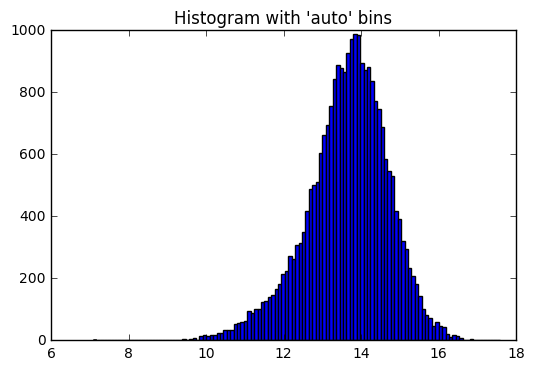

In [29]:
%inline

plt.hist(errors, bins='auto')  # plt.hist passes it's arguments to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [33]:
for index in range(N):
    if inputs[index] != outputs[index]:
        print 'Error'

In [30]:
import caffe
import lmdb

In [37]:
train_inputs = []
train_input_labels = []

lmdb_env = lmdb.open(u'C:\\Users\\Mikhail\\Diploma\\Hieroglyphs_glyphs\\train_lmdb_glyphs')
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()
datum = caffe.proto.caffe_pb2.Datum()

for key, value in lmdb_cursor:
    datum.ParseFromString(value)
    label = datum.label
    data = caffe.io.datum_to_array(datum)
    train_inputs.append(data)
    train_input_labels.append(label)

In [38]:
test_inputs = []
test_input_labels = []

lmdb_env = lmdb.open(u'C:\\Users\\Mikhail\\Diploma\\Hieroglyphs_glyphs\\test_lmdb_glyphs')
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()
datum = caffe.proto.caffe_pb2.Datum()

for key, value in lmdb_cursor:
    datum.ParseFromString(value)
    label = datum.label
    data = caffe.io.datum_to_array(datum)
    test_inputs.append(data)
    test_input_labels.append(label)

In [39]:
train_outputs = []
train_output_labels = []

lmdb_env = lmdb.open(u'C:\\Users\\Mikhail\\Diploma\\Hieroglyphs_glyphs\\train_lmdb_fonts')
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()
datum = caffe.proto.caffe_pb2.Datum()

for key, value in lmdb_cursor:
    datum.ParseFromString(value)
    label = datum.label
    data = caffe.io.datum_to_array(datum)
    train_outputs.append(data)
    train_output_labels.append(label)

In [40]:
test_outputs = []
test_output_labels = []

lmdb_env = lmdb.open(u'C:\\Users\\Mikhail\\Diploma\\Hieroglyphs_glyphs\\test_lmdb_fonts')
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()
datum = caffe.proto.caffe_pb2.Datum()

for key, value in lmdb_cursor:
    datum.ParseFromString(value)
    label = datum.label
    data = caffe.io.datum_to_array(datum)
    test_outputs.append(data)
    test_output_labels.append(label)

In [20]:
for index in range(len(outputs)):
    if input_labels[index] != output_labels[index]:
        print 'Error'

In [21]:
import scipy.misc

In [22]:
inputs[0].shape

(1L, 23L, 23L)

In [24]:
directory = 'test_glyphs\\'

for index in range(len(inputs)):
    scipy.misc.imsave(directory + str(input_labels[index]) + '.jpg', inputs[index][0])

In [35]:
errors = []

In [49]:
for index in range(len(train_outputs)):
    cur_input = train_inputs[index].flatten()
    cur_output = train_outputs[index].flatten()
    
    cur_input = cur_input * 0.0039215684
    cur_output = cur_output * 0.0039215684
    
    errors.append(np.linalg.norm(cur_input - cur_output))
    
for index in range(len(test_outputs)):
    cur_input = test_inputs[index].flatten()
    cur_output = test_outputs[index].flatten()
    
    cur_input = cur_input * 0.0039215684
    cur_output = cur_output * 0.0039215684
    
    errors.append(np.linalg.norm(cur_input - cur_output))

0.0


ERROR:root:Line magic function `%inline` not found.


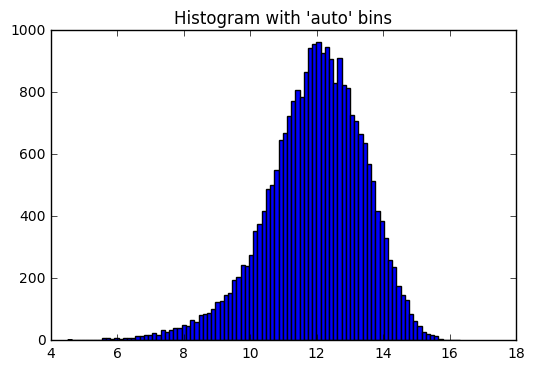

In [46]:
%inline

import matplotlib.pyplot as plt

plt.hist(errors, bins='auto')  # plt.hist passes it's arguments to np.histogram
plt.title("Histogram with 'auto' bins")
plt.savefig('glyph-font.jpg')
plt.show()

In [45]:
plt.savefig('glyph-font.jpg')